In [ ]:
!pip install beautifulsoup4

### Dependencises Installation

In [8]:
import re
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

## For each URL, look for all href elements.


In [2]:
urls = ["https://sanctionssearch.ofac.treas.gov/","https://home.treasury.gov/","https://www.thomsonreuters.com/","https://verafin.com/solution/","https://www.swift.com/","https://anti-fraud.ec.europa.eu/index_en","https://www.kroll.com/","https://learn.seon.io/"]

def get_all_href(url):
    '''
    Fetch all hrefs of given url
    
    parameter
    ----------
    url : string
        URL of webiste to do API call
    
    Returns:
    ----------
    list
        all unique hrefs of url    
        
    '''
    temp_href = []
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    for a in soup.find_all('a', href=True):
        all_href[url]=[]
        if a['href']!='':
            temp_href.append(a['href'])
    return list(set(temp_href))

total_href = 0
all_href = {}

# pass each url to get_all_href
for url in urls:
    all_href[url] = get_all_href(url)
    print(url," = ", len(all_href[url]))
    total_href+=len(all_href[url])

print("total_href = ",total_href)

https://sanctionssearch.ofac.treas.gov/  =  11
https://home.treasury.gov/  =  289
https://www.thomsonreuters.com/  =  121
https://verafin.com/solution/  =  0
https://www.swift.com/  =  207
https://anti-fraud.ec.europa.eu/index_en  =  83
https://www.kroll.com/  =  107
https://learn.seon.io/  =  4
total_href =  822


### Out of these hrefs, filter out first 10 which start with http (or https) and those which do not. That is they have format href=”http://…” or href=https://......”

In [ ]:
def filter_http_https(hrefs,count):
    '''
    Filter first N number of href starting with http or https
    
    paramter
    ---------
    hrefs: dict
        it contains the url as key and hrefs as value
    count: int
        number of filter href required
        
    Returns
    ---------
    list:
        it has len=count with unique values 
    '''
    filtered_href=set()
    for url in hrefs:
        for href in hrefs[url]:
            if href.lower().startswith(('http://', 'https://')):
                if len(filtered_href)==count:
                    break
                filtered_href.add(href)
    return list(filtered_href)       
    
count=10
filtered_href = filter_http_https(all_href,10)
print(filtered_href)

### For each href which starts with http or https, find all links which are valid (which return http status code 200 and those which are not valid). Save as a CSV file.

In [1]:
from multiprocessing.pool import Pool

def valid_http_https(url, all_href,):
    '''
    Check status_code of API response
    
    paramter
    ----------
    url: string
        URL from list1
    all_href: dict
        dict containinng URL against hrefs
        
    Returns
    ---------
    lists
        urls hrefs and validity
    '''
    urls = []
    hrefs = []
    validity = []
    for href in all_href[url]:
        if href.lower().startswith(('http://', 'https://')):
            response = requests.get(href)
            if response.status_code==200:
              urls.append(url)
              hrefs.append(href)
              validity.append("Valid")
            else:
              urls.append(url)
              hrefs.append(href)
              validity.append("Invalid")
    print(len(urls),len(hrefs),len(validity))
    return urls, hrefs, validity 

urls = []
hrefs = []
status = []   
# protect the entry point
with Pool() as pool:
    # prepare arguments
    items = [(url, all_href) for url in list(all_href.keys())[0]]
    # execute tasks and process results in order
    for result in pool.starmap(valid_http_https, items,chunksize=8):
        print(f'Got result: {result}', flush=True)
        url,href,validity = result
        urls.extend(url)
        hrefs.extend(href)
        status.extend(validity)
        
df =pd.DataFrame({"url":urls,"href":hrefs,"Status":status})
df.to_csv("valid_href.csv",index=False)

NameError: name 'all_href' is not defined

### Make a graph which plots each entry in List1 against total number of href links, valid https/https links and invalid https links.

In [ ]:
new_df =df.groupby(['url', 'Status']).size().unstack()
new_df.fillna(0,inplace=True)
new_df["total_href"] = (new_df.Invalid+new_df.Valid).values
new_df

In [ ]:
new_df.plot(kind = 'bar',stacked=True,title = 'Stacked Valid Invalid Count For Urls',figsize=(10,5),width=0.8)
plt.grid()

In [ ]:
new_df.plot(kind = 'bar',title = 'Valid Invalid Count For Urls',figsize=(10,5),width=0.9)
plt.grid()

### For each valid http/ https links or sub links find the website having the highest number of each keyword form list2 in Appendix. Group them by main link from list 1 and then the sub links. Make a csv file.

In [ ]:
keywords = ["Sanctions","OFAC","Foreign Sanctions","Balkans","ESG trends","Corporate income tax","European Parliament","customs fraud","Cybersecurity","OLAF","Device Fingerprinting"]

In [ ]:
df1 = pd.read_csv("valid_href.csv")
df1 = df1[df1.Status=="Valid"]
df1[keywords]=np.nan

hrefs = list(df1.href)
for i in range(len(hrefs)):
    page = requests.get(hrefs[i])
    soup = BeautifulSoup(page.content, "html.parser")
    tag = soup.body
    text =""
    try:
        for string in tag.strings:
            text=text+string.strip()
        word_count = {word:text.count(word) for word in keywords}
        df1.loc[i,keywords] = word_count.values()    
    except:
        df1.loc[i,keywords] = 0
df1.to_csv("word_count.csv",index=False)

In [11]:
import pandas as pd
df1 = pd.read_csv("word_count.csv")
df1["max"]=df1.iloc[:,3:-1].idxmax(axis=1)
df1.head()

,url,href,Status,Sanctions,OFAC,Foreign Sanctions,Balkans,ESG trends,Corporate income tax,European Parliament,customs fraud,Cybersecurity,OLAF,Device Fingerprinting,TotalKeywords,max
0,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,39,24,0,0,0,0,0,0,0,0,0,63,Sanctions
1,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,35,23,1,0,0,0,0,0,0,0,0,59,Sanctions
2,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/office...,Valid,27,32,0,0,0,0,0,0,0,0,0,59,OFAC
3,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,49,12,4,1,0,0,0,0,0,0,0,66,Sanctions
4,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,23,21,0,0,0,0,0,0,0,0,0,44,Sanctions


In [13]:
aggregation_functions = {'max': 'first'}
df_new = df1.groupby(['url','href']).aggregate(aggregation_functions)
df_new = df_new.reset_index()
df_new.to_csv("Max_freq_keyword.csv",index=False)

### Plot a graph showing the number of keywords found in each link and their sub links. Also display the website link having the highest number of keywords and lowest number of keywords. Consider each set of related keywords on a line.


In [5]:
df_grouped = df1.groupby(["url"])["TotalKeywords"].sum()
df_grouped = df_grouped.reset_index()
df_grouped

,url,TotalKeywords
0,https://anti-fraud.ec.europa.eu/index_en,100
1,https://home.treasury.gov/,2311
2,https://learn.seon.io/,0
3,https://sanctionssearch.ofac.treas.gov/,291
4,https://www.kroll.com/,206
5,https://www.swift.com/,61
6,https://www.thomsonreuters.com/,182


<BarContainer object of 7 artists>

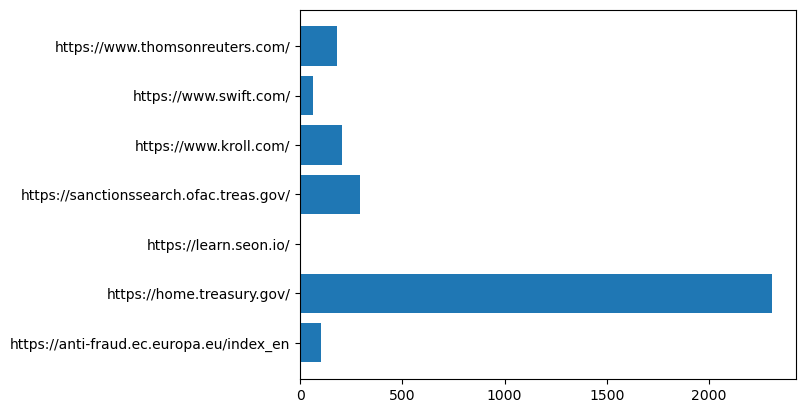

In [9]:
plt.barh(df_grouped.url,df_grouped.TotalKeywords)

<BarContainer object of 2 artists>

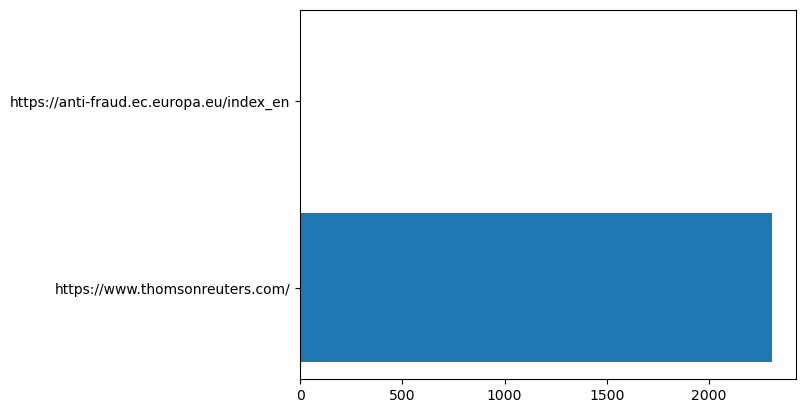

In [10]:
## A website with minimum and maximum keywords
columns = [df_grouped.max()[0],df_grouped.min()[0]] 
values = [df_grouped.max()[1],df_grouped.min()[1]]
plt.barh(columns,values,)